In [1]:
import utils
import plotting
import numpy as np
import warnings
import pandas as pd
from pandas.core.common import SettingWithCopyWarning

# ignore these because they don't seem to apply
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

from PyPDF2 import PdfFileMerger

from copy import deepcopy

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
plot_dir = "../../../plots/ttsfs/23Jan18"

import os

_ = os.system(f"mkdir -p {plot_dir}")

In [19]:
samples = {
    "QCD": "QCD",
    "Single Top": "ST",
    "TTSL": "TTToSemiLeptonic",
    "TTbar": ["TTTo2L2Nu", "TTToHadronic"],
    "W+Jets": "WJets",
    "Diboson": ["WW", "WZ", "ZZ"],
    "Data": "SingleMuon",
}

top_matched_key = "TT Top Matched"

# data_dir = "../../../../data/ttsfs/Dec22/"
data_dir = "../../../../data/ttsfs/Jan17/"
year = "2018"

# filters = [("('ak8FatJetPt', '0')", ">=", 500)]
filters = None

events_dict = utils.load_samples(data_dir, samples, year, filters=filters)

Finding QCD samples
Loading QCD_HT300to500
Loaded 94 entries
Loading QCD_HT200to300
Loaded 0 entries
Loading QCD_HT700to1000
Loaded 1515 entries
Loading QCD_HT1000to1500
Loaded 647 entries
Loading QCD_HT100to200
Loaded 0 entries
Loading QCD_HT2000toInf
Loaded 254 entries
Loading QCD_HT1500to2000
Loaded 596 entries
Loading QCD_HT50to100
Loaded 0 entries
Loading QCD_HT500to700
Loaded 757 entries
Finding Single Top samples
Loading ST_tW_antitop_5f_NoFullyHadronicDecays
Loaded 64727 entries
Loading ST_tW_top_5f_NoFullyHadronicDecays
Loaded 65135 entries
Loading ST_t-channel_top_4f_InclusiveDecays
Loaded 135699 entries
Loading ST_tW_top_5f_inclusiveDecays
Loaded 25268 entries
Loading ST_tW_antitop_5f_inclusiveDecays
Loaded 24203 entries
Loading ST_s-channel_4f_leptonDecays
Loaded 56481 entries
Loading ST_t-channel_top_5f_InclusiveDecays
Loaded 125449 entries
Loading ST_t-channel_antitop_4f_InclusiveDecays
Loaded 69665 entries
Loading ST_t-channel_antitop_5f_InclusiveDecays
Loaded 54301 entr

In [7]:
data_dir = "../../../../data/ttsfs/Dec22/"
sample = "TTToSemiLeptonic"

# utils.get_cutflow(f"{data_dir}/{year}/TTToSemiLeptonic/pickles", year, "TTToSemiLeptonic")
utils.get_cutflow(f"{data_dir}/{year}/{sample}/pickles", year, sample)

# import pickle

# for i in range(68):
#     with open(f"{data_dir}/{year}/{sample}/pickles/out_{i}.pkl", "rb") as file:
#         out_dict = pickle.load(file)[year][sample]['cutflow']
#         print(out_dict["all"])
# utils.get_cutflow(f"{data_dir}/{year}/{sample}/pickles", year, sample)

OrderedDict([('lepW', 1079665.0),
             ('top_has_bs', 665774.0),
             ('ak4_jet', 666328.0),
             ('all', 124529836),
             ('met', 1141398.0),
             ('ak8_jet', 1537404.0),
             ('npvsGood', 124529850.0),
             ('muon', 11072011.0)])

In [20]:
data_dir = "../../../../data/ttsfs/Jan17/"

# utils.get_cutflow(f"{data_dir}/{year}/TTToSemiLeptonic/pickles", year, "TTToSemiLeptonic")
utils.get_cutflow(f"{data_dir}/{year}/{sample}/pickles", year, sample)

# import pickle

# with open(f"{data_dir}/{year}/{sample}/pickles/out_1.pkl", "rb") as file:
#     out_dict = pickle.load(file)[year][sample]['cutflow']
#     print(out_dict)

OrderedDict([('lepW', 6254499.0),
             ('top_has_bs', 1073061.0),
             ('ak4_jet', 1073887.0),
             ('all', 126125558),
             ('trigger', 16197479.0),
             ('met', 6254499.0),
             ('ak8_jet', 1798382.0),
             ('npvsGood', 16197479.0),
             ('muon', 11213765.0)])

In [21]:
events_dict[top_matched_key] = events_dict["TTSL"].loc[events_dict["TTSL"]["top_matched"][0] == 1]
events_dict["TT W Matched"] = events_dict["TTSL"].loc[events_dict["TTSL"]["w_matched"][0] == 1]
events_dict["TT Unmatched"] = pd.concat(
    [events_dict["TTbar"], events_dict["TTSL"].loc[events_dict["TTSL"]["unmatched"][0] == 1]]
)
# del events_dict["TTSL"]
# del events_dict["TTbar"]

In [22]:
# normalize scale factors to average to 1
for key in ["lp_sf", "lp_sf_lnN"]:
    # cut off at 10
    events_dict[top_matched_key].loc[:, key] = np.minimum(
        events_dict[top_matched_key].loc[:, key].values, 10
    )
    mean_lp_sfs = np.mean(events_dict[top_matched_key][key], axis=0)
    events_dict[top_matched_key].loc[:, key] = (
        events_dict[top_matched_key].loc[:, key] / mean_lp_sfs
    ).values


In [23]:
events_dict[top_matched_key]["lp_sf"]

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
25,0.194881,0.143229,0.145240,0.191688,0.271597,0.178414,0.193899,0.297222,0.335740,0.183915,...,0.176832,0.188013,0.169392,0.214567,0.193101,0.350112,0.087229,0.187319,0.279565,0.227756
29,0.927268,0.838453,1.225974,0.154960,0.547234,0.585341,1.030347,0.473482,0.514631,0.139876,...,0.687212,0.000000,0.565651,0.475996,0.762565,0.147238,1.021661,1.009720,0.934985,0.977181
34,0.954582,2.190666,1.113663,1.433547,2.231235,0.697161,0.929176,0.783261,0.912328,1.602099,...,0.975251,1.183961,0.763789,1.508870,1.252697,2.836022,1.146425,0.795331,0.897400,1.714001
61,0.245738,0.539064,0.167096,0.180905,0.161530,0.174874,0.226280,0.120284,0.391742,0.252777,...,0.311005,0.140191,0.277104,0.265095,0.290592,0.282306,0.225007,0.391139,0.056823,0.063698
69,0.929276,2.562561,0.456119,2.310951,0.714961,0.285189,1.550987,0.353113,0.152632,0.552800,...,1.285252,0.674779,0.151941,0.033888,0.436441,0.556575,0.134063,0.562365,0.087894,4.558674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1092708,0.189868,0.413194,0.000000,0.070330,0.211689,0.337527,0.000000,0.000000,1.079760,0.239562,...,0.130720,0.456759,0.543431,0.212298,0.293273,0.039763,0.272369,0.635346,0.000000,0.400390
1092726,0.289015,0.401827,0.377941,0.245484,0.147920,0.143272,0.295785,0.281271,0.549050,0.398655,...,0.160578,0.155791,0.163758,0.825593,0.251253,0.316246,0.145867,0.339489,0.163055,0.321635
1092769,0.094694,0.011433,0.000000,0.259962,0.138573,0.042562,0.000000,0.000000,0.161588,0.141882,...,0.138430,0.089063,0.298497,0.000000,0.000000,0.052694,0.211991,0.277111,0.000000,0.000000
1092786,4.803836,0.556895,0.098158,8.738028,0.251963,8.314058,7.308800,7.916235,4.812342,1.013942,...,0.000000,2.082033,6.913269,5.155649,1.178565,0.360785,7.790595,0.000000,0.379298,0.515064


Text(0.5, 1.0, 'Scale factor distribution')

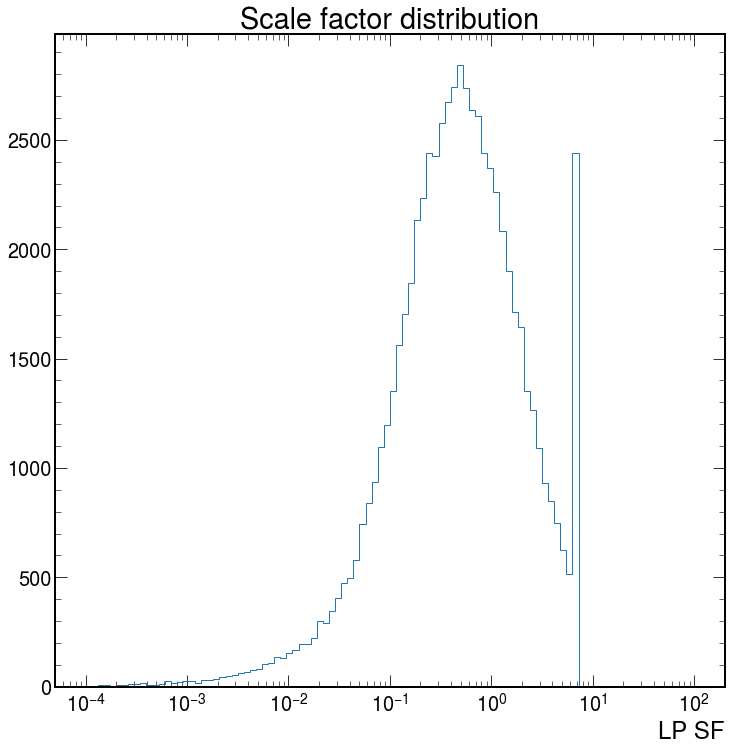

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
_ = plt.hist(events_dict[top_matched_key]["lp_sf"][0].values, np.logspace(-4, 2, 101, base=10), histtype='step')
plt.xscale("log")
# plt.yscale("log")
plt.xlabel("LP SF")
plt.title("Scale factor distribution")

In [25]:
# for key in events_dict:
#     if key == top_matched_key:
#         events_dict[key]["total_weight"] = events_dict[key]["weight"].values * events_dict[key]["lp_sf"]
#         events_dict[key]["total_weight_err"] = (
#             events_dict[key]["weight"] * events_dict[key]["lp_sf_err"]
#         )
#     else:
#         events_dict[key]["total_weight"] = events_dict[key]["weight"]
#         events_dict[key]["total_weight_err"] = events_dict[key]["weight"] * 0

In [26]:
for key in events_dict:
    events_dict[key] = events_dict[key][events_dict[key]["ak8FatJetPt"][0] >= 500]
    events_dict[key] = events_dict[key][events_dict[key]["ak8FatJetMsd"][0] >= 125]
    events_dict[key] = events_dict[key][events_dict[key]["ak8FatJetMsd"][0] <= 225]

In [27]:
plot_samples = [
    "QCD",
    "Diboson",
    "Single Top",
    "W+Jets",
    "TT Unmatched",
    "TT W Matched",
    top_matched_key,
]

### Pre plots

In [ ]:
# {var: (bins, label)}
plot_vars = {
    "ak8FatJetMass": ([20, 125, 225], r"$m_{SD}$ (GeV)"),
    "ak8FatJetPt": ([20, 500, 1200], r"$p_T$ (GeV)"),
    "ak8FatJetnPFCands": ([20, 0, 120], r"# of PF Candidates"),
    "ak8FatJetParticleNet_Th4q": ([20, 0.8, 1], r"ParticleNet $T_{H4q}$ Non-MD"),
    "tau21": ([20, 0.04, 0.8], r"$\tau_{21}$"),
    "tau32": ([20, 0.2, 1], r"$\tau_{32}$"),
    "tau43": ([20, 0.42, 1], r"$\tau_{43}$"),
}

pre_hists = {}

for var, (bins, label) in plot_vars.items():
    if var not in pre_hists:
        pre_hists[var] = utils.singleVarHistNoMask(
            events_dict, var, bins, label, weight_key="weight"
        )

merger_pre_plots = PdfFileMerger()

for var, var_hist in pre_hists.items():
    name = f"{plot_dir}/pre_{var}.pdf"
    plotting.ratioLinePlot(
        var_hist,
        plot_samples,
        year,
        bg_err=None,
        name=name,
    )
    merger_pre_plots.append(name)

merger_pre_plots.write(f"{plot_dir}/PrePlots.pdf")
merger_pre_plots.close()

### Post plots

In [ ]:
post_hists = {}
post_hists_err = {}

events = events_dict[top_matched_key]

for var, (bins, label) in plot_vars.items():
    if var not in post_hists:
        toy_hists = []
        for i in range(events["lp_sf"].shape[1]):
            toy_hists.append(
                np.histogram(
                    events[var][0].values.squeeze(),
                    np.linspace(*bins[1:], bins[0] + 1),
                    weights=events["weight"][0].values * events["lp_sf"][i].values,
                )[0]
            )

        nom_vals = toy_hists[0]  # first column are nominal values
        unc = np.minimum(nom_vals, np.std(toy_hists[1:], axis=0))  # cap at 100% unc

        thist = deepcopy(pre_hists[var])
        top_matched_key_index = np.where(np.array(list(thist.axes[0])) == top_matched_key)[0][0]
        thist.view(flow=False)[top_matched_key_index, :].value = nom_vals
        post_hists[var] = thist
        post_hists_err[var] = unc


merger_post_plots = PdfFileMerger()

for var, var_hist in post_hists.items():
    name = f"{plot_dir}/post_{var}.pdf"
    plotting.ratioLinePlot(
        var_hist,
        plot_samples,
        year,
        bg_err=post_hists_err[var],
        name=name,
    )
    merger_post_plots.append(name)

merger_post_plots.write(f"{plot_dir}/PostPlots.pdf")
merger_post_plots.close()

### Post LnN Plots

In [ ]:
post_hists = {}
post_hists_err = {}

events = events_dict[top_matched_key]

for var, (bins, label) in plot_vars.items():
    if var not in post_hists:
        toy_hists = []
        for i in range(events["lp_sf_lnN"].shape[1]):
            toy_hists.append(
                np.histogram(
                    events[var][0].values.squeeze(),
                    np.linspace(*bins[1:], bins[0] + 1),
                    weights=events["weight"][0].values * events["lp_sf_lnN"][i].values,
                )[0]
            )

        nom_vals = toy_hists[0]  # first column are nominal values
        unc = np.minimum(nom_vals, np.std(toy_hists, axis=0))  # cap at 100% unc

        thist = deepcopy(pre_hists[var])
        top_matched_key_index = np.where(np.array(list(thist.axes[0])) == top_matched_key)[0][0]
        thist.view(flow=False)[top_matched_key_index, :].value = nom_vals
        post_hists[var] = thist

        post_hists_err[var] = unc


merger_post_plots = PdfFileMerger()

for var, var_hist in post_hists.items():
    name = f"{plot_dir}/postlnN_{var}.pdf"
    plotting.ratioLinePlot(
        var_hist,
        plot_samples,
        year,
        bg_err=post_hists_err[var],
        name=name,
    )
    merger_post_plots.append(name)

# merger_post_plots.write(f"{plot_dir}/PostLnNPlots.pdf")
# merger_post_plots.close()

In [22]:
mass_hist = utils.singleVarHistNoMask(
    events_dict, "ak8FatJetMass", [20, 125, 225], r"$m_{SD}$", weight_key="weight"
)

In [ ]:
plotting.ratioHistPlot(
    mass_hist,
    ["QCD", "Diboson", "Single Top", "W+Jets", "TT Unmatched", "TT W Matched", top_matched_key],
    f"{plot_dir}/",
)